# 1. Text Processing

In this section we'll discuse dataset reading and preprocessing.
As well we'll show various visualizations that might help us understand topic more deeply.

## 1.1. Loading up the Dataset

In [2]:
import pandas as pd

full_df = pd.read_csv('./full-corpus.csv', header=0)

In [3]:
# We can show up the dimensions of our dataframe.
# Basicaly number of data points and variables
print(full_df.shape)

(5113, 5)


In [4]:
# Also variables of our dataframe can be showed.
print(*full_df.columns, sep = ', ')

Topic, Sentiment, TweetId, TweetDate, TweetText


In [5]:
neutral_df = full_df[full_df['Sentiment'] == 'neutral']
irrelevant_df = full_df[full_df['Sentiment'] == 'irrelevant']
negative_df = full_df[full_df['Sentiment'] == 'negative']
positive_df = full_df[full_df['Sentiment'] == 'positive']

neutral_downsampled = neutral_df.sample(n=len(negative_df) + len(positive_df), replace=False, random_state=42)

full_df = pd.concat([neutral_downsampled, irrelevant_df, negative_df, positive_df])

full_df = full_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [6]:
# Lets look into distribution of data points in observable classes.
print(full_df['Sentiment'].value_counts())
print(full_df['Topic'].value_counts())

Sentiment
irrelevant    1689
neutral       1091
negative       572
positive       519
Name: count, dtype: int64
Topic
microsoft    1020
google       1002
twitter       979
apple         870
Name: count, dtype: int64


In [7]:
# As well as verbose information about them.
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3871 entries, 0 to 3870
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Topic      3871 non-null   object
 1   Sentiment  3871 non-null   object
 2   TweetId    3871 non-null   int64 
 3   TweetDate  3871 non-null   object
 4   TweetText  3871 non-null   object
dtypes: int64(1), object(4)
memory usage: 151.3+ KB


In [8]:
# Finally we can print first $n$ points of our dataframe.
full_df.head()

,Topic,Sentiment,TweetId,TweetDate,TweetText
0,microsoft,negative,126689051960033280,Wed Oct 19 15:59:58 +0000 2011,Totally unproductive day with no access to #Mi...
1,microsoft,positive,126742063961214976,Wed Oct 19 19:30:37 +0000 2011,Hey parents!Did you know about the free tools ...
2,twitter,irrelevant,126878849656037377,Thu Oct 20 04:34:09 +0000 2011,Porque mi app de #Twitter para #Android no act...
3,twitter,irrelevant,126869070292320256,Thu Oct 20 03:55:18 +0000 2011,Llega un momento que #twitter es tu desahogo
4,microsoft,negative,126700315507572736,Wed Oct 19 16:44:43 +0000 2011,"#BOFH excuse #447: According to #Microsoft, it..."


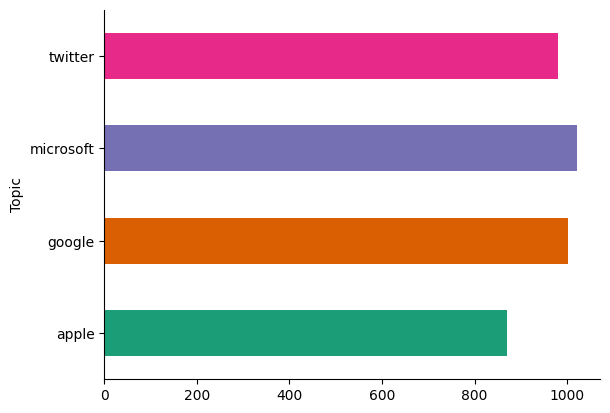

In [9]:
from matplotlib import pyplot as plt
import seaborn as sns
full_df.groupby('Topic').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

## 1.2. Visualizing the dataset

We can leverage libraries like `matplotlib` to visualize dataframe content.
Since our variables mostly strings, there are not much to visualize :(

In [10]:
# We can see how sentiment distributed across topics.
pd.crosstab(index=full_df['Sentiment'], columns=full_df['Topic'])

Topic,apple,google,microsoft,twitter
Sentiment,,,,
irrelevant,139,479,500,571
negative,316,57,132,67
neutral,251,264,297,279
positive,164,202,91,62


## 1.3. Sanitize Dataset

This section clears up provided text data by masking unresolvable tokens
(such as: URLs, timestamps, Emojis...) and resolving contractions and leftovers.

We're keeping hashtags and tags,
as they might be helpful with Sentiment and Topic analysis.

In [11]:
import re, json, unicodedata

class sanitizer:
    def __init__(self):
        # Recognizing of the following texts.
        self.regex_definitions = {
            'URL': r'(?xi)\b(?:(?:https?|ftp|file):\/\/|www\.|ftp\.|pic\.|twitter\.|facebook\.)(?:\([-A-Z0-9+&@#\/%=~_|$?!:;,.]*\)|[-A-Z0-9+&@#\/%=~_|$?!:;,.])*(?:\([-A-Z0-9+&@#\/%=~_|$?!:,.]*\)|[A-Z0-9+&@#\/%=~_|$])',
            'EMOJI': u'([\U0001F1E0-\U0001F1FF])|([\U0001F300-\U0001F5FF])|([\U0001F600-\U0001F64F])|([\U0001F680-\U0001F6FF])|([\U0001F700-\U0001F77F])|([\U0001F800-\U0001F8FF])|([\U0001F900-\U0001F9FF])|([\U0001FA00-\U0001FA6F])|([\U0001FA70-\U0001FAFF])|([\U00002702-\U000027B0])|([\U00002600-\U000027BF])|([\U0001f300-\U0001f64F])|([\U0001f680-\U0001f6FF])',
            'HASHTAG': r'\#\b[\w\-\_]+\b',
            'EMAIL': r'(?:^|(?<=[^\w@.)]))(?:[\w+-](?:\.(?!\.))?)*?[\w+-]@(?:\w-?)*?\w+(?:\.(?:[a-z]{2,})){1,3}(?:$|(?=\b))',
            'CASHTAG': r"(?:[$\u20ac\u00a3\u00a2]\d+(?:[\\.,']\d+)?(?:[MmKkBb](?:n|(?:il(?:lion)?))?)?)|(?:\d+(?:[\\.,']\\d+)?[$\u20ac\u00a3\u00a2])",
            'DATE': r"(?:(?:(?:(?:(?<!:)\b\'?\d{1,4},? ?)?\b(?:[Jj]an(?:uary)?|[Ff]eb(?:ruary)?|[Mm]ar(?:ch)?|[Aa]pr(?:il)?|May|[Jj]un(?:e)?|[Jj]ul(?:y)?|[Aa]ug(?:ust)?|[Ss]ept?(?:ember)?|[Oo]ct(?:ober)?|[Nn]ov(?:ember)?|[Dd]ec(?:ember)?)\b(?:(?:,? ?\'?)?\d{1,4}(?:st|nd|rd|n?th)?\b(?:[,\\/]? ?\'?\d{2,4}[a-zA-Z]*)?(?: ?- ?\d{2,4}[a-zA-Z]*)?(?!:\d{1,4})\b))|(?:(?:(?<!:)\b\\'?\d{1,4},? ?)\b(?:[Jj]an(?:uary)?|[Ff]eb(?:ruary)?|[Mm]ar(?:ch)?|[Aa]pr(?:il)?|May|[Jj]un(?:e)?|[Jj]ul(?:y)?|[Aa]ug(?:ust)?|[Ss]ept?(?:ember)?|[Oo]ct(?:ober)?|[Nn]ov(?:ember)?|[Dd]ec(?:ember)?)\b(?:(?:,? ?\'?)?\d{1,4}(?:st|nd|rd|n?th)?\b(?:[,\\/]? ?\'?\d{2,4}[a-zA-Z]*)?(?: ?- ?\d{2,4}[a-zA-Z]*)?(?!:\d{1,4})\b)?))|(?:\b(?<!\d\\.)(?:(?:(?:[0123]?[0-9][\\.\\-\\/])?[0123]?[0-9][\\.\\-\\/][12][0-9]{3})|(?:[0123]?[0-9][\\.\\-\\/][0123]?[0-9][\\.\\-\\/][12]?[0-9]{2,3}))(?!\.\d)\b))",
            'TIME': r'(?:(?:\d+)?\\.?\d+(?:AM|PM|am|pm|a\\.m\\.|p\\.m\\.))|(?:(?:[0-2]?[0-9]|[2][0-3]):(?:[0-5][0-9])(?::(?:[0-5][0-9]))?(?: ?(?:AM|PM|am|pm|a\\.m\\.|p\\.m\\.))?)',
            'EMPHASIS': r'(?:\*\b\w+\b\*)',
            'ELONG': r'\b[A-Za-z]*([a-zA-Z])\1\1[A-Za-z]*\b'
        }

        # Array of companies to consider valuable.
        self.companies = full_df['Topic'].unique()

        # Reading contractions dictionary.
        with open(r'./contractions.json', 'r') as f:
            self.contractions = json.load(f)

        # Reading emoticons bindings.
        with open(r'./emoticons.json', 'r') as f:
            self.emoticons = json.load(f)

        # Reading slang leftovers dictionary.
        with open(r'./leftovers.json', 'r') as f:
            self.leftovers = json.load(f)

    # Compiles regex_definitions.
    def get_compiled(self):
        regexes = {k: re.compile(v) for k, v in
                   self.regex_definitions.items()}
        return regexes

    # Sanitizes text data.
    def transform(self, data: str):
        # Sanitize unresolvable tokens.
        for key, value in self.get_compiled().items():
            data = value.sub(f'<{key}>', data)

        # Sanitize emoticons.
        for key, value in self.emoticons.items():
            data = data.replace(key, value)

        # Normalize casing.
        data = data.lower()

        # Sanitize contractions.
        for key, value in self.contractions.items():
            regex = re.compile(f'\b{key}\b')
            data = regex.sub(value, data)

        # Substitute comapny tag with their name.
        for item in self.companies:
            substr = f'@{item}'
            data = data.replace(substr, item)

        # Convert other tags to masks.
        data = re.sub(r'@[A-Za-z0-9]+', '<MENTION>', data)

        # Remove hashes from hashtags.
        data = re.sub(r'#\b', '', data)

        # Sanitize symbols, encoding, single letters and personality type nonsense.
        data = re.sub(r"[\-\"`@#$%^&*(|)/~\[\]{\}:;+,._='!?]+", " ", data)
        data = unicodedata.normalize('NFKD', data).encode('ascii', errors='ignore').decode('utf8',errors='ignore')
        data = re.sub(r'\b([b-hB-Hj-zJ-Z] )', ' ', data)
        data = re.sub(r'( [b-hB-Hj-zJ-Z])\b', ' ', data)

        # Normalize spaces
        data = ' '.join(data.split())

        # Sanitize leftovers
        for key, value in self.leftovers.items():
            data = data.replace(key, value)

        return data

In [12]:
# Working non-destuctevly: creating new column with sanitized data in dataframe.
full_df['TweetTextSanitized'] = full_df['TweetText'].apply(sanitizer().transform)

In [13]:
full_df[['TweetText', 'TweetTextSanitized']].head()

,TweetText,TweetTextSanitized
0,Totally unproductive day with no access to #Mi...,totally unproductive day with no access to <ha...
1,Hey parents!Did you know about the free tools ...,hey parents did you know about the free tools ...
2,Porque mi app de #Twitter para #Android no act...,porque mi app de <hashtag> para <hashtag> no a...
3,Llega un momento que #twitter es tu desahogo,llega un momento que <hashtag> es tu desahogo
4,"#BOFH excuse #447: According to #Microsoft, it...",<hashtag> excuse <hashtag> according to <hasht...


## 1.4. Stemming, Lemmantizing and Featuring

In this section we'll convert tokens of provided tweets to infinitives,
so it would be easier to feature them to their Sentiment meaning (example: love -> positive, hate -> negative, fine -> neutral).

In [31]:
import string
import collections
import sys

import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer

class featurer:
    def __init__(self):
        # Download dictionaries.
        nltk.download('vader_lexicon', quiet=True)
        nltk.download('wordnet', quiet=True)
        nltk.download('stopwords', quiet=True)

        # Define classes.
        self.lemma = WordNetLemmatizer()
        self.stem = PorterStemmer()
        self.stopwords = set(stopwords.words('english'))
        self.sia = SentimentIntensityAnalyzer()

        # Words bindings
        self.bindings, self.categories = self.readDict(r'./LIWC2015_English.dic')

    def readDict(self, dictionaryPath):
        catList = collections.OrderedDict()
        catLocation = []
        wordList = {}
        finalDict = collections.OrderedDict()

        # Check to make sure the dictionary is properly formatted
        with open(dictionaryPath, "r") as dictionaryFile:
            for idx, item in enumerate(dictionaryFile):
                if "%" in item:
                    catLocation.append(idx)
            if len(catLocation) > 2:
                # There are apparently more than two category sections; throw error and die
                sys.exit("Invalid dictionary format. Check the number/locations of the category delimiters (%).")

        # Read dictionary as lines
        with open(dictionaryPath, "r") as dictionaryFile:
            lines = dictionaryFile.readlines()

        # Within the category section of the dictionary file, grab the numbers associated with each category
        for line in lines[catLocation[0] + 1:catLocation[1]]:
            try:
                if re.split(r'\t+', line)[0] == '':
                    catList[re.split(r'\t+', line)[1]] = [re.split(r'\t+', line.rstrip())[2].split()[0]]
                else:
                    catList[re.split(r'\t+', line)[0]] = [re.split(r'\t+', line.rstrip())[1].split()[0]]
            except: # likely category tags
                pass

        # Now move on to the words
        for idx, line in enumerate(lines[catLocation[1] + 1:]):
            # Get each line (row), and split it by tabs (\t)
            workingRow = re.split('\t', line.rstrip())
            wordList[workingRow[0]] = list(workingRow[1:])

        # Merge the category list and the word list
        for key, values in wordList.items():
            if "(" in key and ")" in key:
                key = key.replace("(","").replace(")","")
            # these words are ambiguous and cause errors
            if key == "kind" or key== "like":
                continue
            if not key in finalDict:
                finalDict[key] = []
            for catnum in values:
                try: # catch errors (e.g. with dic formatting)
                    workingValue = catList[catnum][0].split()[0]
                    finalDict[key].append(workingValue)
                except:
                    print(catnum)
        return finalDict, catList.values()

    def sentimize(self, word, sentiment=True):
        # Calculate sentiment of the word.
        scores = self.sia.polarity_scores(word)

        if sentiment:
          if scores['compound'] >= 0.03:
              return 'fine'
          elif scores['compound'] >= 0.05:
              return 'positive'
          elif scores['compound'] >= 0.08:
              return 'brilliant'

          if scores['compound'] <= -0.03:
              return 'meh'
          elif scores['compound'] <= -0.05:
              return 'negative'
          elif scores['compound'] <= -0.08:
              return 'worst'

        stemed = self.stem.stem(word)

        if stemed in self.bindings:
            return self.bindings[stemed][len(self.bindings[stemed]) - 1]
        elif stemed + '*' in self.bindings:
            return self.bindings[stemed + '*'][len(self.bindings[stemed + '*']) - 1]
        else:
            return stemed

    def transform(self, data, sentiment=True):
        # Erase maskings.
        data = re.sub(r'<[A-Z]+>', '', data)
        data = ''.join([char for char in data if char not in string.punctuation])

        tokenizer = RegexpTokenizer(r'\w+')
        tokens = tokenizer.tokenize(data)

        # Remove stopwords.
        tokens = [token for token in tokens if not token in self.stopwords]

        # Bind words to their sentiment.
        tokens = [self.sentimize(token, sentiment) for token in tokens]

        return ' '.join(tokens)

    def transform_basic(self, data):
      return self.transform(data, False)

    def transform_sentiment(self, data):
      return self.transform(data, True)


In [32]:
# Working non-destuctevly: creating new column with sanitized data in dataframe.
full_df['TweetTextFeatured'] = full_df['TweetTextSanitized'].apply(featurer().transform_sentiment)
full_df['TweetTextFeaturedBasic'] = full_df['TweetTextSanitized'].apply(featurer().transform_basic)

In [33]:
full_df[['TweetTextSanitized', 'TweetTextFeatured', 'TweetTextFeaturedBasic']].head(15)

,TweetTextSanitized,TweetTextFeatured,TweetTextFeaturedBasic
0,totally unproductive day with no access to <ha...,certain unproduct time reward netspeak fine wo...,certain unproduct time reward netspeak work wo...
1,hey parents did you know about the free tools ...,informal affiliation focuspresent fine tool ne...,informal affiliation focuspresent money tool n...
2,porque mi app de <hashtag> para <hashtag> no a...,porqu mi netspeak de netspeak para netspeak ac...,porqu mi netspeak de netspeak para netspeak ac...
3,llega un momento que <hashtag> es tu desahogo,llega un momento que netspeak es tu desahogo,llega un momento que netspeak es tu desahogo
4,<hashtag> excuse <hashtag> according to <hasht...,netspeak fine netspeak accord netspeak design ...,netspeak social netspeak accord netspeak desig...
5,rt <MENTION> <hashtag> <hashtag> <hashtag> <ha...,assent netspeak netspeak netspeak netspeak url,assent netspeak netspeak netspeak netspeak url
6,christina hendricks et sean faris dans nfs est...,christina hendrick et sean fari dan nf est auj...,christina hendrick et sean fari dan nf est auj...
7,funny <hashtag> <hashtag> google <hashtag> ran...,fine netspeak netspeak google netspeak power n...,funni netspeak netspeak google netspeak power ...
8,<MENTION> beleza mande mesmo por dm que assim ...,beleza mand mesmo por netspeak que assim que e...,beleza mand mesmo por netspeak que assim que e...
9,so cutting the cord makes podcasts even harder...,meh cord focuspresent leisure adverb feel mana...,negemo cord focuspresent leisure adverb feel m...


# 2. Vectorizing & Training Classifier

Creaing vectorizer and classifier pipeline.
Training them and test.

## 2.1. Sentiment Classification

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer

In [38]:
# Encode labels.
sentiment_encoder = LabelEncoder()
label = sentiment_encoder.fit_transform(full_df['Sentiment'])

sentiment_clf = Pipeline([
    # Count features in the data.
    ('vect', CountVectorizer(max_features=5000)),
    # Convert data to tf-idf features.
    ('tfidf', TfidfTransformer()),
    # Linear SVM with stochastic gradiend decent training.
    # As MulibinomialNB() was one of the most perfomant.
    # SGD oftenly regarded as the best classificator of scikit.
    ('clf', SGDClassifier(loss='hinge', penalty='l2',
                           alpha=1e-3, random_state=42,
                           max_iter=1000)),
])

# Divide the test suite.
x_train, x_test, y_train, y_test = train_test_split(full_df['TweetTextFeatured'], label, test_size=0.2, random_state=42)

# Train the model.
sentiment_clf.fit(x_train, y_train)

# Evaluate predictment.
y_pred = sentiment_clf.predict(x_test)

# Report perfomance.
print(classification_report(y_test, y_pred, target_names=sentiment_encoder.classes_))

              precision    recall  f1-score   support

  irrelevant       0.79      0.91      0.84       338
    negative       0.58      0.56      0.57       113
     neutral       0.64      0.60      0.62       227
    positive       0.57      0.36      0.44        97

    accuracy                           0.70       775
   macro avg       0.64      0.61      0.62       775
weighted avg       0.69      0.70      0.69       775



In [35]:
# Divide the test suite.
x_train, x_test, y_train, y_test = train_test_split(full_df['TweetTextFeaturedBasic'], label, test_size=0.2, random_state=42)

# Train the model.
sentiment_clf.fit(x_train, y_train)

# Evaluate predictment.
y_pred = sentiment_clf.predict(x_test)

# Report perfomance.
print(classification_report(y_test, y_pred, target_names=sentiment_encoder.classes_))

              precision    recall  f1-score   support

  irrelevant       0.78      0.93      0.85       338
    negative       0.61      0.59      0.60       113
     neutral       0.66      0.62      0.64       227
    positive       0.63      0.30      0.41        97

    accuracy                           0.71       775
   macro avg       0.67      0.61      0.62       775
weighted avg       0.70      0.71      0.70       775



## 2.2. Topic Classification

In [19]:
topic_encoder = LabelEncoder()
label = topic_encoder.fit_transform(full_df['Topic'])

topic_clf = Pipeline([
    ('vect', CountVectorizer(max_features=1000)),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l2',
                           alpha=1e-3, random_state=42,
                           max_iter=1000)),
])

x_train, x_test, y_train, y_test = train_test_split(full_df['TweetTextFeatured'], label, test_size=0.2, random_state=42)

topic_clf.fit(x_train, y_train)

y_pred = topic_clf.predict(x_test)

print(classification_report(y_test, y_pred, target_names=topic_encoder.classes_))

              precision    recall  f1-score   support

       apple       0.97      0.98      0.98       181
      google       0.93      0.56      0.70       198
   microsoft       0.74      0.76      0.75       210
     twitter       0.65      0.90      0.75       186

    accuracy                           0.79       775
   macro avg       0.82      0.80      0.79       775
weighted avg       0.82      0.79      0.79       775

